## Graph

### MAE: random_masking

In [148]:
x = torch.rand((4, 5, 2))
x

tensor([[[0.4242, 0.2900],
         [0.3482, 0.5577],
         [0.2255, 0.1098],
         [0.8989, 0.5212],
         [0.7968, 0.0127]],

        [[0.3815, 0.1038],
         [0.2913, 0.9885],
         [0.6024, 0.2209],
         [0.1044, 0.9607],
         [0.6929, 0.2405]],

        [[0.1717, 0.6199],
         [0.4443, 0.0392],
         [0.0725, 0.5095],
         [0.2704, 0.8845],
         [0.1892, 0.1595]],

        [[0.6444, 0.4932],
         [0.7901, 0.1293],
         [0.1907, 0.7914],
         [0.7692, 0.4905],
         [0.1445, 0.6353]]])

In [62]:
noise = torch.rand(4, 5)
noise

tensor([[0.0835, 0.5561, 0.9291, 0.7978, 0.9702],
        [0.5953, 0.2089, 0.5204, 0.3862, 0.4703],
        [0.1807, 0.2943, 0.8598, 0.4118, 0.7235],
        [0.1801, 0.3224, 0.7655, 0.5698, 0.9442]])

In [63]:
ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
ids_shuffle

tensor([[0, 1, 3, 2, 4],
        [1, 3, 4, 2, 0],
        [0, 1, 3, 4, 2],
        [0, 1, 3, 2, 4]])

In [64]:
ids_restore = torch.argsort(ids_shuffle, dim=1)
ids_restore

tensor([[0, 1, 3, 2, 4],
        [4, 0, 3, 1, 2],
        [0, 1, 4, 2, 3],
        [0, 1, 3, 2, 4]])

In [65]:
ids_keep = ids_shuffle[:, :3]
ids_keep

tensor([[0, 1, 3],
        [1, 3, 4],
        [0, 1, 3],
        [0, 1, 3]])

In [66]:
x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, 2))
x_masked

tensor([[[0.0841, 0.7777],
         [0.2600, 0.6878],
         [0.5623, 0.3064]],

        [[0.5746, 0.9682],
         [0.3447, 0.8661],
         [0.1676, 0.4896]],

        [[0.4387, 0.9735],
         [0.8970, 0.7504],
         [0.7708, 0.4949]],

        [[0.0260, 0.9256],
         [0.9354, 0.9779],
         [0.6392, 0.9462]]])

In [67]:
mask = torch.ones([4, 5], device=x.device)
mask[:, :3] = 0
# unshuffle to get the binary mask
mask = torch.gather(mask, dim=1, index=ids_restore)
mask

tensor([[0., 0., 1., 0., 1.],
        [1., 0., 1., 0., 0.],
        [0., 0., 1., 0., 1.],
        [0., 0., 1., 0., 1.]])

### Debug:

In [1]:
import moco as moco

print(moco.__dict__['moco_graph_encoder'])

<function moco_graph_encoder at 0x7f81808a4790>


In [13]:
h_pl = torch.rand((4, 2))
c = torch.rand((4, 2))
print(h_pl)
print(c)

tensor([[0.0808, 0.9130],
        [0.8778, 0.8021],
        [0.0944, 0.6027],
        [0.2141, 0.1238]])
tensor([[0.8555, 0.2620],
        [0.9656, 0.1462],
        [0.1758, 0.5150],
        [0.4018, 0.3649]])


In [14]:
import torch.nn as nn

n_h = 2
f_k = nn.Bilinear(n_h, n_h, 1)

scs = []
scs.append(f_k(h_pl, c))
scs

[tensor([[ 0.3055],
         [ 0.4926],
         [-0.1603],
         [-0.1570]], grad_fn=<AddBackward0>)]

In [15]:
c_mi = c
negsamp_round = 1
for _ in range(negsamp_round):
    c_mi = torch.cat((c_mi[-2:-1,:], c_mi[:-1,:]),0)
    print(c_mi)
    scs.append(f_k(h_pl, c_mi))

tensor([[0.1758, 0.5150],
        [0.8555, 0.2620],
        [0.9656, 0.1462],
        [0.1758, 0.5150]])


In [17]:
print(scs)

[tensor([[ 0.3055],
        [ 0.4926],
        [-0.1603],
        [-0.1570]], grad_fn=<AddBackward0>), tensor([[-0.1441],
        [ 0.3266],
        [ 0.2137],
        [-0.2137]], grad_fn=<AddBackward0>)]


In [16]:
logits = torch.cat(tuple(scs))
logits

tensor([[ 0.3055],
        [ 0.4926],
        [-0.1603],
        [-0.1570],
        [-0.1441],
        [ 0.3266],
        [ 0.2137],
        [-0.2137]], grad_fn=<CatBackward0>)

In [18]:
x = torch.rand((4, 5, 2))
x

tensor([[[0.2789, 0.2368],
         [0.8589, 0.8995],
         [0.1355, 0.6173],
         [0.6932, 0.8482],
         [0.6499, 0.5748]],

        [[0.4149, 0.4989],
         [0.7000, 0.2095],
         [0.5814, 0.5955],
         [0.2664, 0.6382],
         [0.3337, 0.7935]],

        [[0.2979, 0.6018],
         [0.3499, 0.3546],
         [0.2195, 0.0341],
         [0.2673, 0.9819],
         [0.3262, 0.5714]],

        [[0.9486, 0.0165],
         [0.0677, 0.1777],
         [0.0727, 0.1079],
         [0.3486, 0.1212],
         [0.0447, 0.4711]]])

In [19]:
x[:, 0, :]

tensor([[0.2789, 0.2368],
        [0.4149, 0.4989],
        [0.2979, 0.6018],
        [0.9486, 0.0165]])

In [57]:
from dgl.nn.pytorch.glob import AvgPooling

avg = AvgPooling()

out = avg(temp, temp.ndata["features"])
print(out.shape)

torch.Size([1, 1433])


In [58]:
out = out.to(torch.float32)

In [59]:
drop = nn.Dropout(0.2)
linear = nn.Linear(1433, 32)
out = drop(linear(out))
print(out.shape)

torch.Size([1, 32])


In [60]:
score_over_layer = 0
score_over_layer += out

In [62]:
score_over_layer.shape

torch.Size([1, 32])

In [91]:
import torch

# Sinkhorn-Knopp
def sinkhorn(scores, eps=0.05, niters=3):
    Q = torch.exp(scores / eps).T
    Q /= sum(Q)
    K, B = Q.shape
    u, r, c = torch.zeros(K), torch.ones(K) / K, torch.ones(B) / B
    for _ in range(niters):
        u = torch.sum(Q, dim=1)
        Q *= (r / u).unsqueeze(1)
        Q *= (c / torch.sum(Q, dim=0)).unsqueeze(0)
    return (Q / torch.sum(Q, dim=0, keepdim=True)).T

z = torch.randn((4, 2))
print(z)

tensor([[-0.4061, -0.9381],
        [-0.6663,  0.9505],
        [ 0.6383,  1.0689],
        [ 1.8522, -0.2765]])


In [93]:
x = sinkhorn(z)
x

tensor([[9.9998e-01, 2.3970e-05],
        [9.0603e-15, 1.0000e+00],
        [1.8182e-04, 9.9982e-01],
        [1.0000e+00, 3.2391e-19]])

In [150]:
a = torch.rand((1, 4))
print(a)
b = F.softmax(a, dim=1)
print(b)

tensor([[0.8667, 0.7765, 0.2961, 0.1600]])
tensor([[0.3365, 0.3074, 0.1902, 0.1660]])


In [151]:
T = 0.8
numerator = np.exp(a) / T
print(numerator)

tensor([[2.9739, 2.7173, 1.6808, 1.4670]])


### Mahalanobis

In [268]:
# load networks
from resnet import ResNet34
model = ResNet34(num_c=10)

# set information about feature extaction
model.eval()
temp_x = torch.rand(32, 3, 32, 32)
temp_x = temp_x.detach()
temp_list = model.feature_list(temp_x)[1] # (B, C, H, W)
num_output = len(temp_list)
print("num of layers: ", num_output)
for i in range(len(temp_list)):
    print("size of each layer: ", temp_list[i].shape)

feature_list = np.empty(num_output) # [0] * num_layers
count = 0
for out in temp_list:
    feature_list[count] = out.size(1) # C
    count += 1
print("feature_list:", feature_list)

num of layers:  5
size of each layer:  torch.Size([32, 64, 32, 32])
size of each layer:  torch.Size([32, 64, 32, 32])
size of each layer:  torch.Size([32, 128, 16, 16])
size of each layer:  torch.Size([32, 256, 8, 8])
size of each layer:  torch.Size([32, 512, 4, 4])
feature_list: [ 64.  64. 128. 256. 512.]


In [269]:
out_features = temp_list
for i in range(num_output):
    out_features[i] = out_features[i].view(out_features[i].size(0), out_features[i].size(1), -1) # (B, C, H*W)
    out_features[i] = torch.mean(out_features[i].data, 2) # (B, C)
    print(out_features[i].data.shape)

torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32, 128])
torch.Size([32, 256])
torch.Size([32, 512])


In [271]:
num_classes = 10
num_sample_per_class = np.empty(num_classes) # [0] * 10
num_sample_per_class.fill(0)
list_features = []
for i in range(num_output):
    temp_list = [] # [0] * 10
    for j in range(num_classes):
        temp_list.append(0)
    list_features.append(temp_list) # [[0] * 10] * num_layers

target = torch.randint(0, 10, (32, ))
data = temp_x

# construct the sample matrix
for i in range(data.size(0)): # [0, B-1]
    label = target[i]
    if num_sample_per_class[label] == 0:
        out_count = 0
        for out in out_features: # out: (B, num_feature)
            list_features[out_count][label] = out[i].view(1, -1) # (1, num_feature)
            out_count += 1
    else:
        out_count = 0
        for out in out_features:
            list_features[out_count][label] \
            = torch.cat((list_features[out_count][label], out[i].view(1, -1)), 0)
            out_count += 1                
    num_sample_per_class[label] += 1

In [275]:
# (num_layers, num_class, N_c, C)
print(len(list_features))
print(len(list_features[0]))
tmp = 0
for i in range(num_classes):
    tmp += len(list_features[0][i])
print(tmp)
print(len(list_features[0][0][0]))

5
10
32
64


In [286]:
sample_class_mean = [] # [(num_classes, C)] * num_layers
out_count = 0
for num_feature in feature_list: # num_layers
    temp_list = torch.Tensor(num_classes, int(num_feature)) # (num_classes, C)
    for j in range(num_classes):
        temp_list[j] = torch.mean(list_features[out_count][j], 0) # (N_c, C) -> (1, C)
    sample_class_mean.append(temp_list)
    out_count += 1
print(len(sample_class_mean))
print(sample_class_mean[0].shape)

5
torch.Size([10, 64])


In [293]:
import sklearn.covariance

group_lasso = sklearn.covariance.EmpiricalCovariance(assume_centered=False)

precision = []
for k in range(num_output):
    X = 0
    for i in range(num_classes):
        if i == 0:
            X = list_features[k][i] - sample_class_mean[k][i] # (N_c, C)
        else:
            X = torch.cat((X, list_features[k][i] - sample_class_mean[k][i]), 0) # (N, C)
    # find inverse            
    group_lasso.fit(X.numpy())
    temp_precision = group_lasso.precision_
    temp_precision = torch.from_numpy(temp_precision).float() # (C, N)
    precision.append(temp_precision) # [(C, N)] * num_layers
print(len(precision))
print(precision[0].shape) # [(C, C)] * num_layers

5
torch.Size([64, 64])


In [345]:
x = torch.randn((3, 2)) # (B, C)
sigma = torch.randn((2, 2)) # (C, C)
print(x)
print(sigma)

tensor([[ 0.4317,  0.1070],
        [-0.3850, -0.6187],
        [ 0.4838,  0.0031]])
tensor([[-2.2033,  2.2806],
        [ 0.0719,  1.6152]])


In [353]:
y = torch.mm(torch.mm(x, sigma), x.t()).diag()
y = y.view(-1, 1)
print(y.shape)

torch.Size([3, 1])


In [358]:
t = torch.randn((3, 1))
t = torch.cat((y, t), 1)
print(t)
print(t.shape)

tensor([[-0.2834,  0.0621],
        [ 0.8519, -0.5122],
        [-0.5122,  0.8572]])
torch.Size([3, 2])


In [361]:
t.max(1)

torch.return_types.max(
values=tensor([0.0621, 0.8519, 0.8572]),
indices=tensor([1, 0, 1]))

In [374]:
x = torch.randn((4, 2))
y = torch.randn((4, 2))
z = torch.sum(x * y, dim=1)
print(z.shape)
z

torch.Size([4])


tensor([ 0.1002, -1.0799,  0.3467,  0.8103])

In [376]:
for i in range(4):
    print(sum(x[i]*y[i]))    

tensor(0.1002)
tensor(-1.0799)
tensor(0.3467)
tensor(0.8103)


In [12]:
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import silhouette_score

# 生成一些示例数据
np.random.seed(42)
X = np.random.rand(100, 2)

# 计算协方差矩阵的逆
cov_matrix_inv = np.linalg.inv(np.cov(X, rowvar=False))

# 中心化数据集
mean = np.mean(X, axis=0)
X_centered = X - mean

# 变换数据集
X_transformed = np.dot(X_centered, cov_matrix_inv)

# 使用 scikit-learn 的 KMeans 基于欧氏距离
kmeans_euclidean = KMeans(n_clusters=2, init='k-means++', n_init='auto', algorithm='lloyd', random_state=42)
kmeans_euclidean.fit(X)

# 使用 scikit-learn 的 KMeans 基于马氏距离
kmeans_mahalanobis = KMeans(n_clusters=2, init='k-means++', n_init='auto', algorithm='lloyd', random_state=42)
kmeans_mahalanobis.fit(X_transformed)

# 获取聚类结果
labels_euclidean = kmeans_euclidean.labels_
labels_mahalanobis = kmeans_mahalanobis.labels_

# 打印聚类结果
print("基于欧氏距离的 K-means 聚类结果：", labels_euclidean)
print("基于马氏距离的 K-means 聚类结果：", labels_mahalanobis)

# 计算基于马氏距离的 K-means 聚类的轮廓系数
silhouette_score_ou = silhouette_score(X, labels_mahalanobis)
silhouette_score_mahalanobis = silhouette_score(X_transformed, labels_mahalanobis)

# 打印基于马氏距离的 K-means 聚类的轮廓系数
print("基于马氏距离的 K-means 聚类的轮廓系数：", silhouette_score_ou)
print("基于马氏距离的 K-means 聚类的轮廓系数：", silhouette_score_mahalanobis)


基于欧氏距离的 K-means 聚类结果： [0 0 1 0 0 0 1 1 0 1 1 1 0 0 1 1 0 0 1 1 0 0 0 0 1 0 0 0 1 1 1 1 0 0 0 1 0
 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0 1 0 1 1 0 0 1 0 0 1 1 0 0 1 1 1 0 0 1 1 1 0
 1 1 0 1 0 0 0 0 0 1 0 1 1 1 1 1 1 0 0 0 1 0 0 1 0 0]
基于马氏距离的 K-means 聚类结果： [0 0 1 0 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 0 0 1 1 0 0 0 1 1 1 1 1 0 0 1 0
 0 1 1 0 1 1 0 0 0 0 0 1 1 0 1 1 0 1 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 1 1 0
 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 1 0 0 1 0 0]
基于马氏距离的 K-means 聚类的轮廓系数： 0.3397246387107845
基于马氏距离的 K-means 聚类的轮廓系数： 0.3736980583593435


### 调试

In [6]:
import math
import dgl
import time
import torch
import numpy as np
import random
import warnings
# from functools import partial
from utils import *
import clustering
from deprecated.dataset import GraphDataset
from deprecated.model import dmc
from sklearn.metrics import roc_auc_score

In [15]:
import torch
import numpy as np
from utils import *
from deprecated.dataset import GraphDataset

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
adj, features, labels, ano_labels = load("cora")
print(type(adj))
# adj = adj.todense()
features = preprocess_features(features)
features = torch.FloatTensor(features)
print("feature_dim: ", features.shape)
# adj = torch.FloatTensor(adj)
labels = torch.FloatTensor(labels)

train_dataset = GraphDataset(adj=adj, features=features, aug=None)
train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=256,
        collate_fn=labeled_batcher(),
        shuffle=True,
        pin_memory=True,
        sampler=None,
        drop_last=True
    )

<class 'scipy.sparse._csr.csr_matrix'>
feature_dim:  torch.Size([2708, 1433])


In [2]:
ano_labels

array([1, 0, 1, ..., 0, 0, 0], dtype=uint8)

In [6]:
# testing
test_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=args.batch_size,
    collate_fn=labeled_batcher(),
    shuffle=False,
    pin_memory=True,
    drop_last=True
)

test_anomaly(test_loader, model, device)

0

In [4]:
g = dgl.DGLGraph()
g.add_nodes(3)
g.add_edges([0, 0, 1, 2], [1, 2, 2, 1])
g.ndata["pos_directed"] = torch.rand(3, 16)
g.ndata["pos_undirected"] = torch.rand(3, 16)
g.ndata["seed"] = torch.zeros(3, dtype=torch.long)
g.ndata["nfreq"] = torch.ones(3, dtype=torch.long)
g.edata["efreq"] = torch.ones(4, dtype=torch.long)
g = dgl.batch([g, g, g])

In [6]:
adj_matrix = g.adjacency_matrix_scipy(transpose=False, return_edge_ids=False).astype(float)
adj_matrix

<9x9 sparse matrix of type '<class 'numpy.float64'>'
	with 12 stored elements in Compressed Sparse Row format>

In [20]:
node_idx = np.array([0, 1, 2, 3])
other_node_idx = node_idx

In [8]:
traces = dgl.contrib.sampling.random_walk_with_restart(
        g,
        seeds=[0],
        restart_prob=0.8,
        max_nodes_per_seed=10,
    )

In [12]:
traces[0]

(tensor([2]),
 tensor([2, 1]),
 tensor([2]),
 tensor([1]),
 tensor([2]),
 tensor([1, 2, 1]),
 tensor([2]))

In [11]:
x = torch.randint(0, 10, (4, 3))
x

tensor([[6, 1, 8],
        [7, 3, 9],
        [2, 6, 2],
        [6, 8, 1]])

In [12]:
index = [0, 1, 2, 1]
x[torch.arange(x.shape[0]), index].unsqueeze(dim=-1)

tensor([[6],
        [3],
        [2],
        [8]])

In [18]:
from utils import *
import scipy.sparse as sps

# 定义稀疏矩阵的维度
rows = 5
cols = 5
density = 0.1  # 非零元素的密度

# 生成稀疏矩阵
sparse_matrix = sps.rand(rows, cols, density=density, format='csr')  # 使用 CSR 格式

# 打印稀疏矩阵
print(sparse_matrix)

  (4, 0)	0.8808502039804483
  (4, 3)	0.2673632621598774


In [33]:
bf = torch.randn((2, 4, 2))
print(bf)
added_feat_zero_row = torch.zeros((2, 1, 2))

x = torch.cat((bf[:, :-1, :], added_feat_zero_row, bf[:, -1:, :]), dim=1)
print(x)

tensor([[[ 1.5412,  0.2360],
         [-0.2304, -0.4119],
         [-0.8034, -2.0590],
         [ 0.6286, -0.2682]],

        [[-0.0031, -0.6970],
         [ 0.6435, -0.0482],
         [-1.5100,  0.2715],
         [ 0.2424,  0.8881]]])
tensor([[[ 1.5412,  0.2360],
         [-0.2304, -0.4119],
         [-0.8034, -2.0590],
         [ 0.0000,  0.0000],
         [ 0.6286, -0.2682]],

        [[-0.0031, -0.6970],
         [ 0.6435, -0.0482],
         [-1.5100,  0.2715],
         [ 0.0000,  0.0000],
         [ 0.2424,  0.8881]]])


In [55]:
x = torch.randn((4, 1, 2)).squeeze(1)
y = torch.randn((4, 1, 2)).squeeze(1)

print(x.T @ y)
print(x @ x.T)

tensor([[-0.4130, -0.2592],
        [ 0.8878, -0.6031]])
tensor([[ 1.8484, -0.7599,  1.4779, -0.3576],
        [-0.7599,  1.8589, -1.9591,  0.4323],
        [ 1.4779, -1.9591,  2.3628, -0.5353],
        [-0.3576,  0.4323, -0.5353,  0.1218]])


In [43]:
import torch.nn as nn
tmp = []
b = nn.Bilinear(2, 2, 1)

for _ in range(5):
    tmp.append(b(x, y))

In [49]:
tmp = torch.cat(tuple(tmp))

In [50]:
tmp

tensor([[-0.0415],
        [ 1.2506],
        [ 0.2615],
        [ 1.0512],
        [-0.0415],
        [ 1.2506],
        [ 0.2615],
        [ 1.0512],
        [-0.0415],
        [ 1.2506],
        [ 0.2615],
        [ 1.0512],
        [-0.0415],
        [ 1.2506],
        [ 0.2615],
        [ 1.0512],
        [-0.0415],
        [ 1.2506],
        [ 0.2615],
        [ 1.0512]], grad_fn=<CatBackward0>)

In [52]:
cur_batch_size = 4
n = torch.unsqueeze(torch.cat(
                    (torch.ones(cur_batch_size), torch.zeros(cur_batch_size * 4))), 1)
n.shape

torch.Size([20, 1])

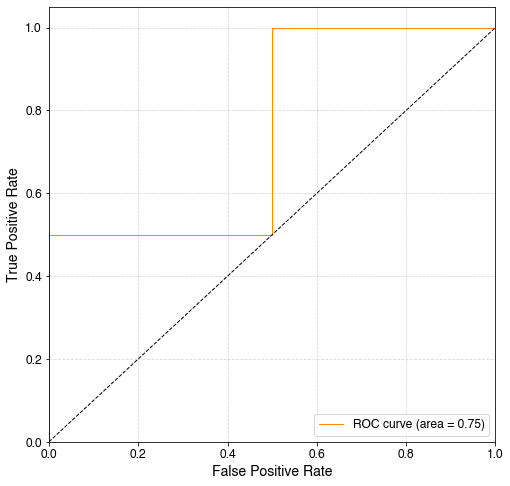

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

labels = np.array([0, 0, 1, 1])
score = np.array([0.1, 0.4, 0.35, 0.8])

fpr, tpr, _ = roc_curve(score, labels)

# 计算AUC
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure(figsize=(8, 8))
# 或者全局设置字体为Arial
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['font.size'] = 12

plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.grid(True, linestyle='--', alpha=0.5)  # 网格线风格为虚线，透明度为0.5
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
# plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('./fig/test.png', dpi=600, bbox_inches='tight')
plt.show()


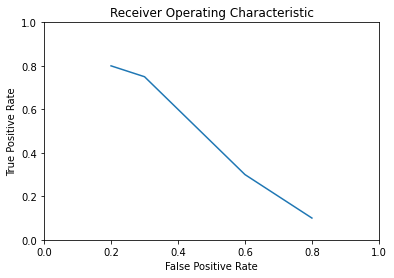

In [62]:
import numpy as np
import matplotlib.pyplot as plt

# 假设我们有如下数据：
true_positive_rate = [0.8, 0.75, 0.6, 0.45, 0.3, 0.2, 0.1]
false_positive_rate = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

# 创建一个figure和一个子图
fig, ax = plt.subplots()

# 绘制ROC曲线
ax.plot(false_positive_rate, true_positive_rate)

# 设置x轴和y轴的范围
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

# 添加标题和标签
ax.set_title('Receiver Operating Characteristic')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

plt.show()

In [ ]:
import seaborn as sns
from sklearn.manifold import TSNE

def visualize(X, labels, savepath=None):
	"""
	绘制t-SNE降维可视化图
	"""
	tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
	out = tsne.fit_transform(X)

	plt.figure(figsize=(10, 8))
	sns.set_theme(style="darkgrid", rc={"axes.linewidth": 1, "axes.edgecolor": "black"})

	for label in np.unique(labels):
		plt.scatter(out[labels == label, 0], out[labels == label, 1], label=f'Cluster {label}', cmap='viridis')

	plt.legend(loc='upper right')
	# plt.title("Test Visualization")
	# 隐藏坐标轴
	plt.xticks([])
	plt.yticks([])
	# plt.axis('off')
	
	if savepath:
		plt.savefig(savepath, dpi=600, bbox_inches='tight')
	# 显示图
	plt.show()

In [ ]:
# from sklearn.metrics import roc_curve, auc

# def plot_multiple_roc_curves(true_labels, scores_list, model_names, save_path=None):
#     plt.figure(figsize=(8, 8))
#     sns.set(style="whitegrid")

#     for i in range(len(scores_list)):
#         fpr, tpr, _ = roc_curve(true_labels, scores_list[i])
#         roc_auc = auc(fpr, tpr)
        
#         sns.lineplot(x=fpr, y=tpr, label=f'{labels[i]} (AUC = {roc_auc:.2f})')

#     plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
#     plt.title('Comparison with baselines', style='italic')
#     plt.xlabel('False Positive Rate (FPR)')
#     plt.ylabel('True Positive Rate (TPR)')
#     plt.legend()
#     if save_path:
#         plt.savefig(save_path, dpi=600)
#     plt.show()

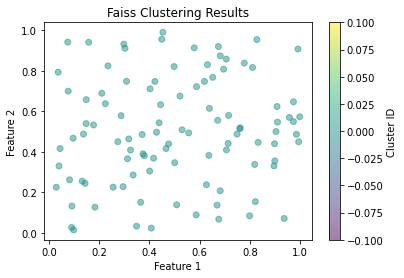

In [64]:
import numpy as np
import faiss
import matplotlib.pyplot as plt

# 示例数据，假设clustered_data是Faiss聚类后的结果
clustered_data = np.random.rand(100, 2)
labels = np.zeros(100)

# 绘制聚类结果
plt.scatter(clustered_data[:, 0], clustered_data[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Faiss Clustering Results')
plt.colorbar(label='Cluster ID')
plt.show()


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import faiss

# 生成示例数据
X, _ = make_blobs(n_samples=1000, centers=5, random_state=42)

# 转换数据类型为32位浮点数
X = X.astype('float32')

# 设置K均值聚类参数
k = 5
d = X.shape[1]

# 初始化K均值聚类器
kmeans = faiss.Kmeans(d, k)

# 训练K均值聚类器
kmeans.train(X)

# 获取聚类中心
centroids = kmeans.centroids

# 获取每个数据点的聚类分配
_, labels = kmeans.index.search(X, 1)

# 绘制聚类结果
plt.figure(figsize=(8, 6))
for i in range(k):
    cluster_points = X[labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i+1}')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', color='k', s=100, label='Centroids')
plt.title('K-Means Clustering with Faiss')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()


IndexError: boolean index did not match indexed array along dimension 1; dimension is 2 but corresponding boolean dimension is 1

<Figure size 576x432 with 0 Axes>

In [4]:
for epoch in range(10):
    print('./fig/' + f'cluster_{epoch+1}.png')

./fig/cluster_1.png
./fig/cluster_2.png
./fig/cluster_3.png
./fig/cluster_4.png
./fig/cluster_5.png
./fig/cluster_6.png
./fig/cluster_7.png
./fig/cluster_8.png
./fig/cluster_9.png
./fig/cluster_10.png


In [6]:
import torch
x = torch.range(0, 10)
x

/var/folders/tn/q17y3xp92zbch3qdjgx30jch0000gn/T/ipykernel_86996/1300981928.py:2: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  x = torch.range(0, 10)


tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [19]:
x = torch.randint(0, 10, (4, 4))
print(x)
_, idx = x.max(dim=1)
print(idx)

tensor([[5, 2, 6, 9],
        [1, 3, 3, 5],
        [6, 1, 2, 0],
        [2, 2, 2, 5]])
tensor([3, 3, 0, 3])


In [26]:
from scipy.sparse import csr_matrix

def get_indices_sparse(data): # (N, 1)
    cols = np.arange(data.size) # [0, ..., N-1]
    M = csr_matrix((cols, (data.ravel(), cols)), shape=(int(data.max()) + 1, data.size))
    return [np.unravel_index(row.data, data.shape) for row in M]

y = get_indices_sparse(idx.cpu().numpy())

In [27]:
y

[(array([2]),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([0, 1, 3]),)]

In [36]:
def gaussian_noised_feature(X):
    """
    add gaussian noise to the attribute matrix X
    Args:
        X: the attribute matrix
    Returns: the noised attribute matrix X_tilde
    """
    N = torch.Tensor(np.random.normal(1, 0.1, X.shape))
    X_tilde = X * N
    return X_tilde

x = torch.randn((1, 4, 2))
print(x)
gaussian_noised_feature(x)

tensor([[[ 0.2374, -2.5983],
         [-1.0370,  1.8456],
         [ 1.1793,  0.4410],
         [-1.0247, -0.8109]]])


tensor([[[ 0.2478, -2.6830],
         [-1.0843,  1.5637],
         [ 1.2341,  0.4952],
         [-1.0640, -0.9281]]])

In [38]:
x = torch.randint(0, 10, (4, ))
x == 1

tensor([False,  True, False, False])

In [2]:
from sklearn.metrics.cluster import normalized_mutual_info_score

# 假设你有两个聚类结果，A和B，它们都是样本索引组成的列表
A = [0, 0, 1, 1, 2, 2, 2]
B = [0, 0, 1, 2, 2, 3, 3]

# 计算NMI
nmi = normalized_mutual_info_score(labels_true=A, labels_pred=B)

print("Normalized Mutual Information (NMI): ", nmi)

Normalized Mutual Information (NMI):  0.7248303282742284


In [19]:
from utils import load_mat

adj, feat, labels, ano_labels, str_ano_labels, attr_ano_labels = load_mat('acm')
print(labels.shape)

(16484, 7)


In [27]:
import torch

a = torch.randint(0, 10, (4, ), dtype=torch.float32)
b = torch.randint(0, 10, (4, ), dtype=torch.float32)
print(a.shape, b)

torch.cosine_similarity(a.unsqueeze(0), b.unsqueeze(0))

torch.Size([4]) tensor([3., 2., 8., 3.])


tensor([0.8374])

In [28]:
def plot_loss_acc_recall(loss_history, val_acc_history, val_recall_history, save_path=None):
    # 创建一个 DataFrame
    epochs = np.arange(1, len(loss_history)+1)
    df_temp = pd.DataFrame({'Epochs': epochs, 'Loss': loss_history, 'Accuracy': val_acc_history, 'Recall': val_recall_history})

    plt.figure(figsize=(10, 6))
    # sns.set(style="darkgrid", rc={"axes.linewidth": 1, "axes.edgecolor": "black"})
    sns.set_theme(style="whitegrid", rc={"axes.linewidth": 1, "axes.edgecolor": "black"})
    ax1 = sns.lineplot(data=df_temp, x='Epochs', y='Loss', label='Loss')
    ax2 = ax1.twinx()  # 创建右边的 Y 轴
    ax2.set_ylim([0, 1.0])

    # 绘制 accuracy 和 recall 的折线
    sns.lineplot(data=df_temp, x='Epochs', y='Accuracy', ax=ax2, color='orange', label='Accuracy')
    sns.lineplot(data=df_temp, x='Epochs', y='Recall', ax=ax2, color='green', label='Recall')

    # 设置左边 Y 轴标签
    ax1.set_ylabel('Loss')

    # 设置右边 Y 轴标签
    ax2.set_ylabel('Accuracy / Recall')

    # 添加标题和标签
    # plt.title('Training Loss, Validation Accuracy and Validation Recall', style = 'italic')
    plt.xlabel('Epochs')

    # 合并图例
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='best')

    # 移除左边 Y 轴的图例
    ax1.legend().set_visible(False)
    
    if save_path:
        plt.savefig(save_path, dpi=600)

tensor(84.)